
# ✈️ AeroConnect Route Analytics & Forecasting

**Author:** Keshav Goel

This notebook explores international route performance for AeroConnect and builds a short-term passenger forecast for selected routes.

## Objectives
1. **Understand the data**
   - Identify highest and lowest trafficked routes
   - Analyze trends and geographical patterns (ports, countries, seasonality)
2. **Build models**
   - Compare classic models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting)
   - Forecast passenger traffic for the next 6–12 months on at least one city pair
3. **Evaluate & recommend**
   - Explain model choices and report accuracy
   - Provide route/network recommendations and how to use the model going forward


## 0) Pip Installs

In [346]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


## 1) Imports & Configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2) Load Data

In [348]:
df = pd.read_csv('csv.csv')
df.head()


,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.17,0.31,985,18.70,0.92,2498,60.87,1.24,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.00,0.00,5,0.03,0.00,17,0.03,0.00,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.00,0.00,5,0.00,0.00,12,0.00,0.00,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.01,0.00,171,0.00,0.25,286,0.01,0.25,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.80,0.00,1472,10.62,2.49,3039,13.42,2.49,1985,1


## 3) Initial Inspection

In [369]:
#Checking if any data is repeated and for the general summary stats of the data
print("Duplicates:", df.duplicated().sum())
df.describe()


Duplicates: 0


,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,"9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00"
mean,"1,489.99",57.58,1.33,"1,439.84",66.32,2.07,"2,929.83",123.90,3.39,"1,986.86",6.20
std,"3,101.65",150.50,5.74,"3,065.38",165.84,6.49,"6,130.62",297.55,10.40,1.30,3.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,985.00",1.00
25%,45.00,0.00,0.00,51.00,0.00,0.00,100.00,0.05,0.00,"1,986.00",3.00
50%,333.00,2.12,0.00,324.00,5.20,0.01,664.00,13.10,0.04,"1,987.00",6.00
75%,"1,586.00",41.67,0.22,"1,535.50",58.67,1.06,"3,131.50",93.72,1.52,"1,988.00",9.00
max,"37,754.00","1,795.48",110.52,"38,475.00","1,899.03",103.11,"70,014.00","3,242.98",197.70,"1,989.00",12.00


In [370]:
#From this we can see that there are no nan values and the general data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

## 4) Cleaning & Feature Engineering

In [ ]:
# Route column to make it easier to visualize the to-and-from
df_new = df.copy()

df_new['route'] = df_new['AustralianPort'].str.strip().str.title() + ' - ' + df_new['ForeignPort'].str.strip().str.title()

# Standardize text columns by removing any trailing spaces and capitalizing
for col in ['AustralianPort','ForeignPort','Country']:
    df_new[col] = df_new[col].astype(str).str.strip().str.title()

# Create date field as a datetime format to make it easier for mdodel
df_new['date'] = pd.to_datetime(df_new['Year'].astype(str) + '-' + df_new['Month_num'].astype(str), format='%Y-%m')

df_new.drop('Month',axis =1,inplace= True)

In [ ]:
#Reorder Dataframe
df_new = df_new[['date','Year','Month_num','route','AustralianPort','ForeignPort','Country','Passengers_In','Passengers_Out','Passengers_Total','Freight_In_(tonnes)','Freight_Out_(tonnes)','Freight_Total_(tonnes)','Mail_In_(tonnes)','Mail_Out_(tonnes)', 'Mail_Total_(tonnes)']]

In [ ]:
#Checking head to make sure it all looks good
df_new.head(5)

,date,Year,Month_num,route,AustralianPort,ForeignPort,Country,Passengers_In,Passengers_Out,Passengers_Total,Freight_In_(tonnes),Freight_Out_(tonnes),Freight_Total_(tonnes),Mail_In_(tonnes),Mail_Out_(tonnes),Mail_Total_(tonnes)
0,1985-01-01,1985,1,Adelaide - Auckland,Adelaide,Auckland,New Zealand,1513,985,2498,42.17,18.70,60.87,0.31,0.92,1.24
1,1985-01-01,1985,1,Adelaide - Bahrain,Adelaide,Bahrain,Bahrain,12,5,17,0.00,0.03,0.03,0.00,0.00,0.00
2,1985-01-01,1985,1,Adelaide - Bombay,Adelaide,Bombay,India,7,5,12,0.00,0.00,0.00,0.00,0.00,0.00
3,1985-01-01,1985,1,Adelaide - Frankfurt,Adelaide,Frankfurt,Germany,115,171,286,0.01,0.00,0.01,0.00,0.25,0.25
4,1985-01-01,1985,1,Adelaide - London,Adelaide,London,Uk,1567,1472,3039,2.80,10.62,13.42,0.00,2.49,2.49


# Task 1: Understanding the data
## 1a) Identifying the most and least trafficked routes

Top 10 Routes:
 route
Sydney - Auckland        2961212
Sydney - Singapore       1440018
Sydney - Tokyo           1292116
Sydney - Hong Kong       1151900
Perth - Singapore         952926
Brisbane - Auckland       893246
Sydney - Christchurch     882357
Melbourne - Singapore     865251
Sydney - Los Angeles      862964
Sydney - Honolulu         861814
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/3201513350.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette='deep')


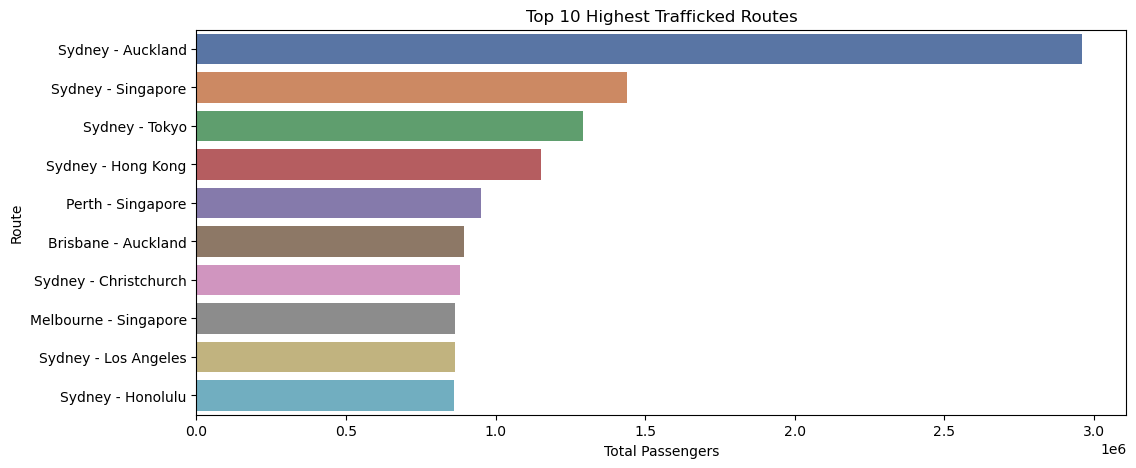

In [372]:
#Creating an aggregated df to see the total passengers by route
route_traffic = df_new.groupby('route')['Passengers_Total'].sum().sort_values(ascending=False)

# Top 10 routes
top_routes = route_traffic.head(10)

print("Top 10 Routes:\n", top_routes)

# Plotting
plt.figure(figsize=(12,5))
sns.barplot(x=top_routes.values, y=top_routes.index, palette='deep')
plt.title("Top 10 Highest Trafficked Routes")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()


Bottom 10 Routes with 0:
 route
Hobart - Los Angeles           2
Hobart - Tokyo                 1
Cairns - Honiara               1
Townsville - San Francisco     1
Darwin - Zagreb                1
Melbourne - Denver             0
Perth - Bandar Seri Begawan    0
Brisbane - Colombo             0
Adelaide - Harare              0
Brisbane - Chicago             0
Name: Passengers_Total, dtype: int64

Bottom 10 Routes, no 0:
 route
Darwin - Zagreb               1
Hobart - Tokyo                1
Townsville - San Francisco    1
Cairns - Honiara              1
Hobart - Los Angeles          2
Perth - Port Moresby          2
Adelaide - Jakarta            3
Hobart - Denpasar             3
Cairns - Belgrade             3
Cairns - Larnaca              4
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/1111951166.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='rocket')


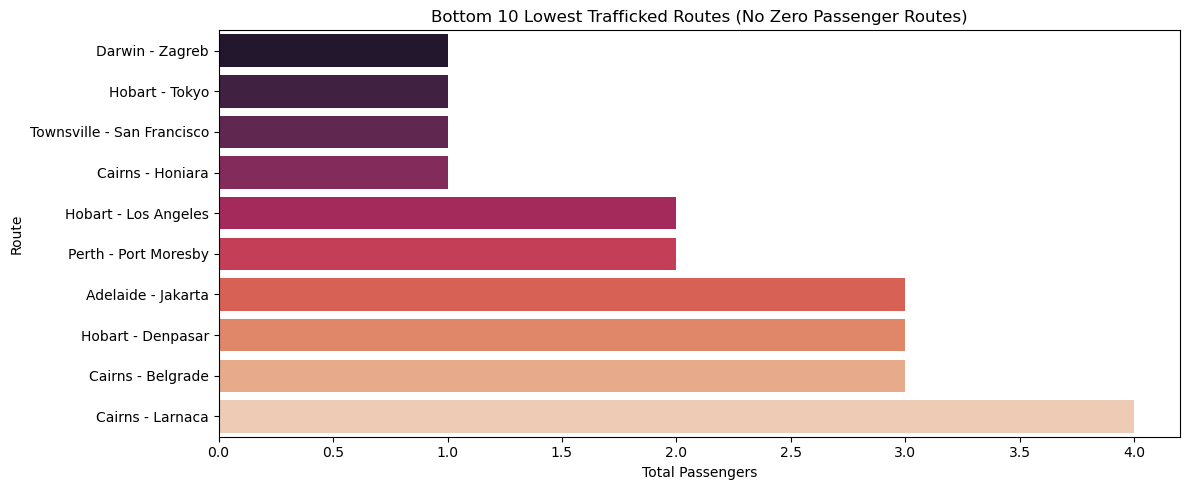

In [ ]:
# Comparing both 0 routes and non-0 routes to allow for greater analysis
nonzero_route_traffic = route_traffic[route_traffic > 0]
bottom_routes_filtered = nonzero_route_traffic.sort_values().head(10)

print("Bottom 10 Routes with 0:\n", route_traffic.tail(10))
print()
print("Bottom 10 Routes, no 0:\n", bottom_routes_filtered)

# Plot bottom 10 non-zero routes
plt.figure(figsize=(12, 5))
sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='rocket')
plt.title("Bottom 10 Lowest Trafficked Routes (No Zero Passenger Routes)")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.tight_layout()
plt.show()


## Task 1b/c: Analyze trends and Visualize them

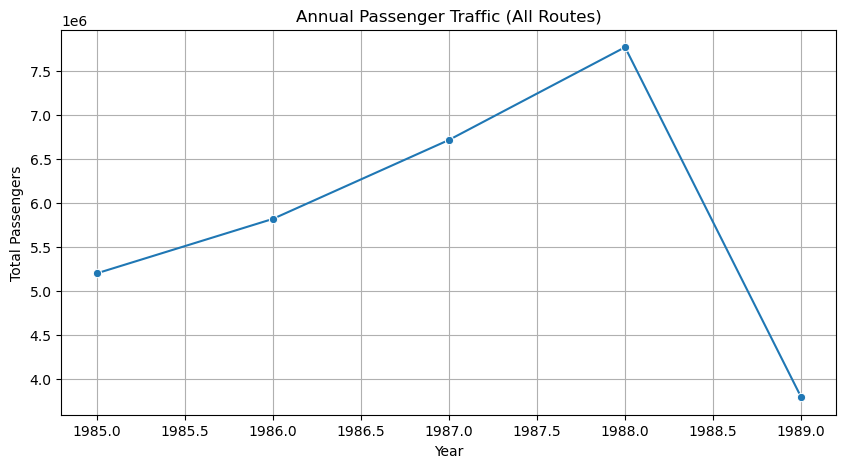

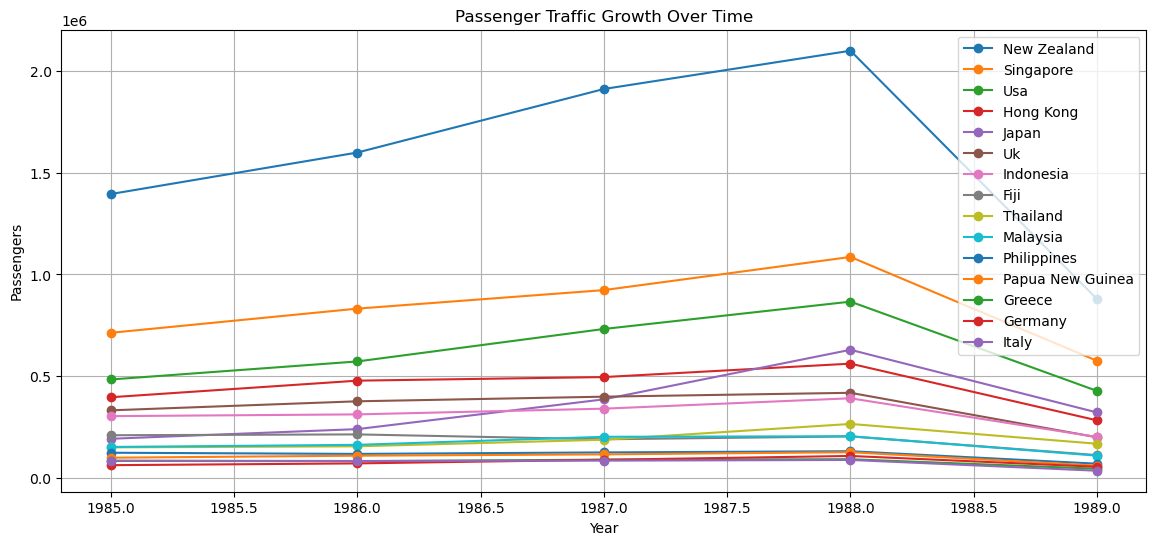

In [ ]:
#Line plot to show both the overall passengers and Individual Country Passengers

#Aggregated by year to show overall
annual_traffic = df_new.groupby('Year')['Passengers_Total'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=annual_traffic.index, y=annual_traffic.values, marker='o')
plt.title("Annual Passenger Traffic (All Routes)")
plt.ylabel("Total Passengers")
plt.xlabel("Year")
plt.grid(True)
plt.show()

#Aggregated dfs for each individual country and relative year
country_year = df_new.groupby(['Year','Country'])['Passengers_Total'].sum().reset_index()
country_traffic = df_new.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14,6))

#Getting all the aggregated passenger data for each country and appending it to the plot
top_countries = country_traffic.index
for c in country_traffic.index:
    subset = country_year[country_year['Country'] == c]
    plt.plot(subset['Year'], subset['Passengers_Total'], marker='o', label=c)

plt.title("Passenger Traffic Growth Over Time")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

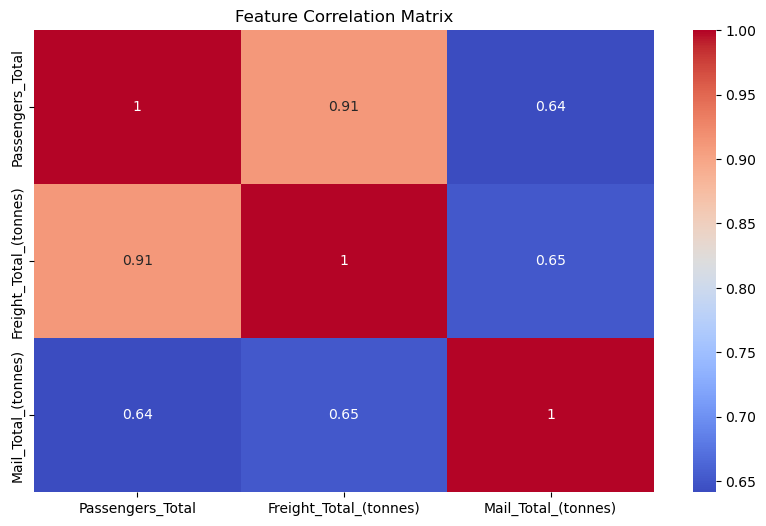

In [ ]:
#Simple Heatmap to see some correlations between features

plt.figure(figsize=(10, 6))
sns.heatmap(df_new[['Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/498265921.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")


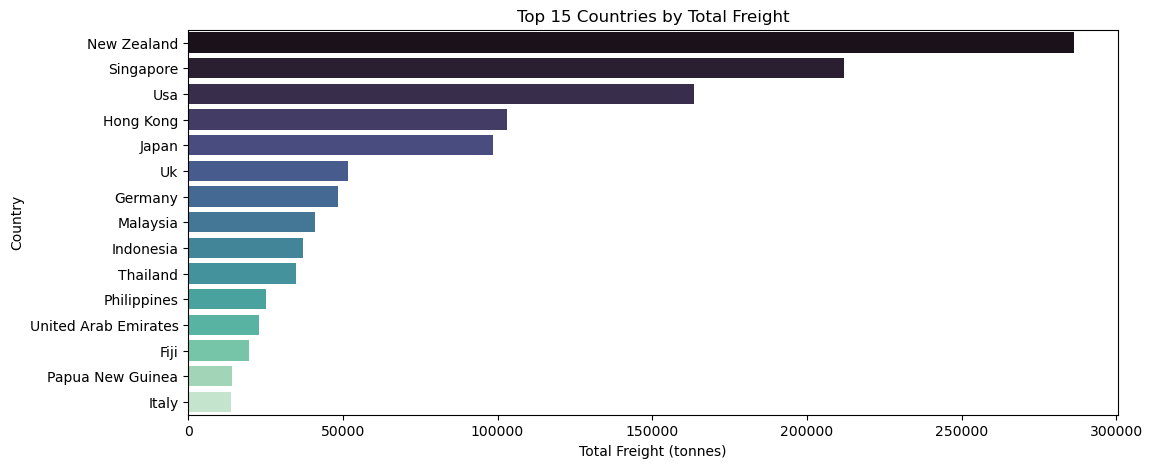

In [ ]:
#Visualizing which countries have the most freight
#Aggregated by Country and total freight
country_freight = df_new.groupby('Country')['Freight_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")
plt.title("Top 15 Countries by Total Freight")
plt.xlabel("Total Freight (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/2055172009.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")


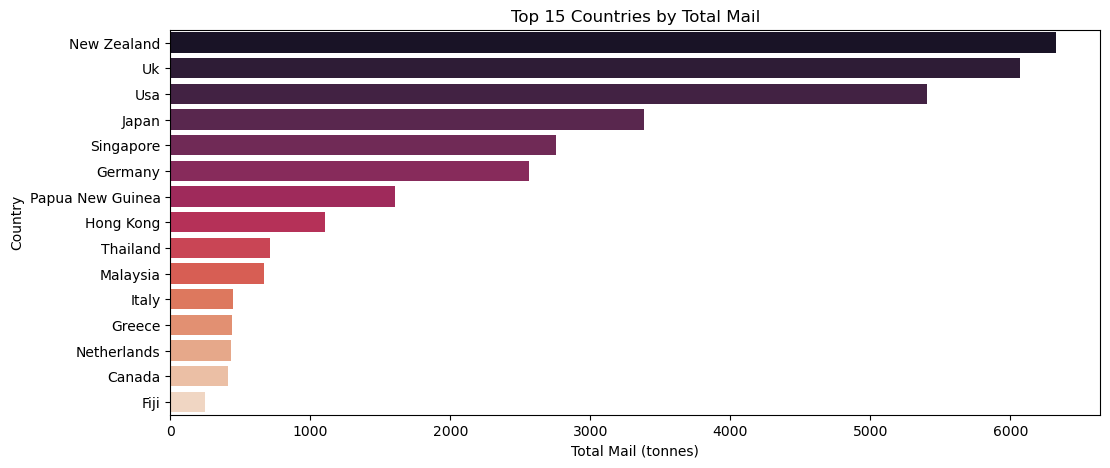

In [ ]:
#Which countries have the most mail
#Aggregated by country and total mail sum
country_mail = df_new.groupby('Country')['Mail_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")
plt.title("Top 15 Countries by Total Mail")
plt.xlabel("Total Mail (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/1867242609.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")


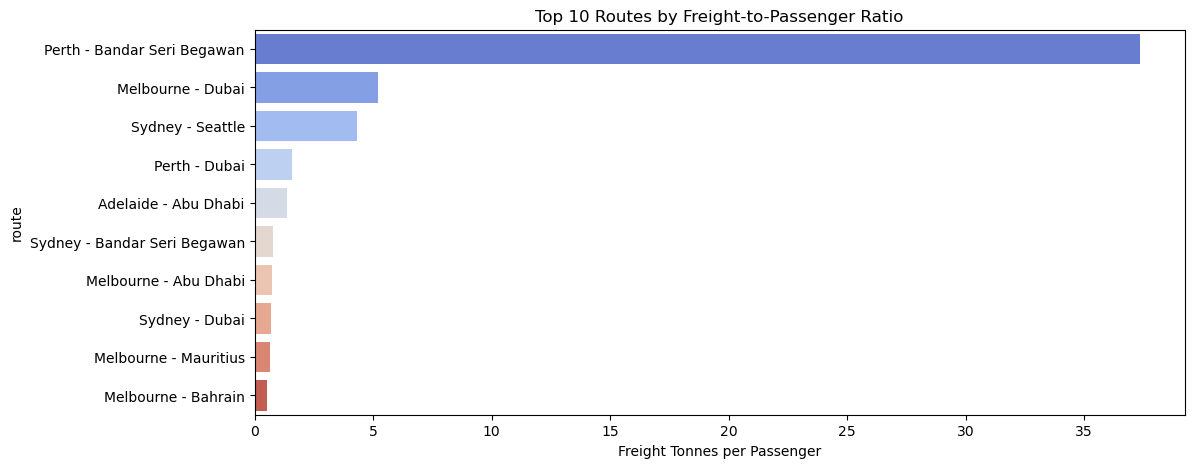

In [383]:
# Freight to Passenger Ratio
# Higher means more freight compared to passengers 

#Creating new column for ratio and then aggregating by route and ratio, this is to see which route is mainly for industrial purposes
df_new['Freight_per_Passenger'] = df_new['Freight_Total_(tonnes)'] / (df_new['Passengers_Total']+1)  
ratio = df_new.groupby('route')['Freight_per_Passenger'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")
plt.title("Top 10 Routes by Freight-to-Passenger Ratio")
plt.xlabel("Freight Tonnes per Passenger")
plt.show()

# Task 2
## 2a) Building and using the model

In [ ]:
# Since we already know Sydney-Auckland is #1 we can just call all the values related to
# that route, and then sort by date to be in chronological order which is important for Prophet
top_route = df_new[df_new['route']=='Sydney - Auckland']
route_df = top_route.sort_values('date')

#Next we intialize a Prophet dataframe since the model looks for certain key column names like ds/datestamp and our target y
df_prophet = route_df[['date', 'Passengers_Total']].rename(columns={'date': 'ds', 'Passengers_Total': 'y'})

# We choose yearly seasonality since travel is seasonal and varies based on things like holidays
# It also allows for the model to learn from seasonal spikes
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)

03:33:24 - cmdstanpy - INFO - Chain [1] start processing
03:33:24 - cmdstanpy - INFO - Chain [1] done processing


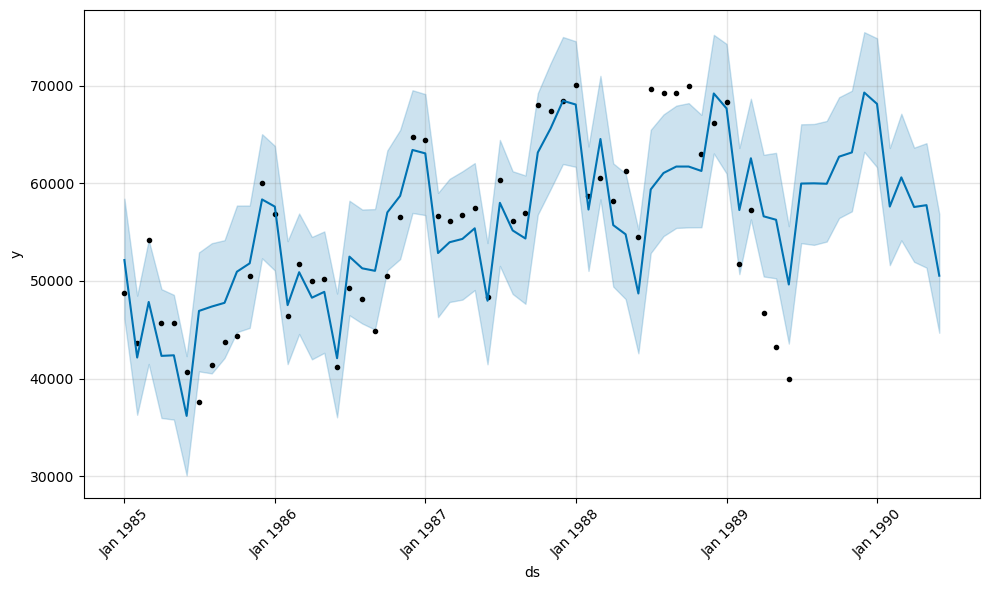

In [384]:
#Make our predictions and then plot them to see accuracy
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)


#Convert the X-axis into an easier to read DateTime format
fig = model.plot(forecast)

ax = fig.gca()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#The solid line represents prophets forecast, dots represent actual data, shaded represents uncertainty interval

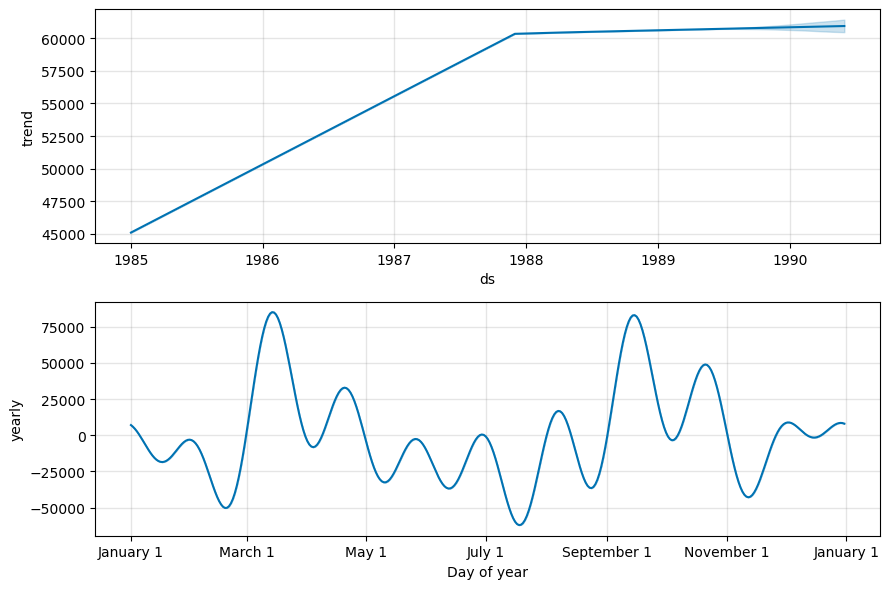

In [386]:
#A more in depth look on Prophet's predictions
fig = model.plot_components(forecast)
ax = fig.gca()

plt.tight_layout()
plt.show()

In [ ]:
# Printing the 12 month forecast that prophet made
print("12 month forecast:\n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

12 month forecast:
            ds      yhat  yhat_lower  yhat_upper
54 1989-07-01 59,969.99   53,867.74   66,035.42
55 1989-08-01 59,993.33   53,693.12   66,066.63
56 1989-09-01 59,950.01   54,033.05   66,375.47
57 1989-10-01 62,723.17   56,441.18   68,802.92
58 1989-11-01 63,156.53   57,124.81   69,469.16
59 1989-12-01 69,281.57   63,207.25   75,462.83
60 1990-01-01 68,123.37   61,643.55   74,836.33
61 1990-02-01 57,616.89   51,619.51   63,611.38
62 1990-03-01 60,602.49   54,157.85   67,113.76
63 1990-04-01 57,570.38   51,957.75   63,644.33
64 1990-05-01 57,758.64   51,362.92   64,101.14
65 1990-06-01 50,542.18   44,696.55   56,863.84


In [ ]:
#Creating a dataframe to get the overall performance of our model
confirmation_df = forecast.set_index('ds')[['yhat']].join(df_prophet.set_index('ds').y).reset_index(drop = True)
confirmation_df.dropna(inplace=True)
confirmation_df.tail()

,yhat,y
49,"57,256.47","51,697.00"
50,"62,559.28","57,288.00"
51,"56,616.54","46,747.00"
52,"56,265.11","43,203.00"
53,"49,641.47","39,950.00"


In [ ]:
# using scikit to get the overall performance and accuracy
print('r2:', r2_score(confirmation_df.y, confirmation_df.yhat))
print('mse:', mean_squared_error(confirmation_df.y, confirmation_df.yhat))
print('mae:', mean_absolute_error(confirmation_df.y, confirmation_df.yhat))

r2: 0.7174804425286274
mse: 24071540.466327913
mae: 3892.2428404301795
